In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Mount the Google Cloud Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Copy cloud disk data to the local PC
!cp -r /content/drive/MyDrive/catdogs/training_set ./training_set
!cp -r /content/drive/MyDrive/catdogs/test_set ./test_set

In [4]:
# Will be in the data set
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),transforms.Resize([224,224])])

train_dataset = datasets.ImageFolder(root='training_set', transform=transform)
test_dataset = datasets.ImageFolder(root='test_set', transform=transform)

In [5]:
print(len(train_dataset))
print(len(test_dataset))

8005
2023


In [6]:
# Partition data set
train_db, val_db = torch.utils.data.random_split(train_dataset, [7000, 1005])

train_loader = DataLoader(train_db, batch_size=32, shuffle=True)
val_loader = DataLoader(val_db, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
# Fine-tuning model structure
class MyViT(nn.Module):
    def __init__(self, model, target_size):
        super(MyViT, self).__init__()
        self.model = model

        for param in self.model.parameters():
          param.requires_grad = False

        n_features = self.model.head.in_features
        # Change the head and change the number of categories
        self.model.head = nn.Linear(n_features, target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [8]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.2 MB/s eta 0:00:00


In [9]:
# Preparation training
device = torch.device("cuda")
model = torch.hub.load('facebookresearch/deit:main','deit_tiny_patch16_224', pretrained=True)

net_base = MyViT(model,2).to(device=device, dtype=torch.float32)
optimizer = torch.optim.Adam([{'params': net_base.model.head.parameters()}], lr=0.001, weight_decay=1e-8)
criterion = nn.CrossEntropyLoss()

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:78: UserWarning: Overwriting deit_small_patch16_224 in registry with models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_small_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:93: UserWarning: Overwriting deit_base_patch16_224 in registry with models.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Plea

In [11]:
MinTrainLoss=999
epochs=5

val_loss = []
val_acc=[]

for epoch in range(1, epochs+1):
    total_train_loss = []
    total_val_loss = []

    # Train
    net_base.train()
    for input_img, label in train_loader:
        input_img = input_img.cuda()
        label = label.cuda()
        optimizer.zero_grad()

        pred_img = net_base(input_img)
        loss = criterion(pred_img, label)
        loss.backward()
        optimizer.step()

    # Verify
    net_base.eval()
    current = 0
    with torch.no_grad():
        for val_img, val_label in val_loader:
            val_img = val_img.cuda()
            val_label = val_label.cuda()

            pred = net_base(val_img)
            total_val_loss.append(criterion(pred, val_label).item())
            current += (pred.argmax(1)==val_label).type(torch.float).sum().item()

    val_loss.append(np.mean(total_val_loss))
    val_acc.append(current/1005*100)

    print("epochs[%3d/%3d] val_loss: %.5f, val_acc: %.3f"%(epoch, epochs, val_loss[-1],val_acc[-1]))

epochs[  1/  5] val_loss: 0.04613, val_acc: 98.607
epochs[  2/  5] val_loss: 0.04085, val_acc: 98.507
epochs[  3/  5] val_loss: 0.04037, val_acc: 98.507
epochs[  4/  5] val_loss: 0.04037, val_acc: 98.607
epochs[  5/  5] val_loss: 0.04074, val_acc: 98.607


In [12]:
net_base.eval()
current = 0
total_test_loss = []
with torch.no_grad():
    for test_img, test_label in test_loader:
        test_img = test_img.cuda()
        test_label = test_label.cuda()

        pred = net_base(test_img)
        total_test_loss.append(criterion(pred, test_label).item())
        current += (pred.argmax(1)==test_label).type(torch.float).sum().item()

print("testdataset test_loss: %.5f, test_acc: %.3f"%(np.mean(total_val_loss), current/2023*100))

testdataset test_loss: 0.04074, test_acc: 98.913


## Attention visualization

In [13]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=b154fa2029ec25bda69f40a428b590b028f78a6b3dd128ca720e50ad379f07d2
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [14]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit

import cv2

In [15]:
def reshape_transform(tensor, height=14, width=14):
    # Drop cls token
    result = tensor[:,1:,:].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    print("result:",result.shape)

    return result

In [16]:
# Preparing the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize([224,224])])

dataset = datasets.ImageFolder(root='test_set',transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
model = net_base.model.cuda()

for param in model.parameters():
  param.requires_grad = True

# Create a GradCAM object
cam = GradCAM(model = model,target_layers=[model.blocks[-1].norm1], use_cuda=True, reshape_transform = reshape_transform)

In [27]:
# Take the picture
rgb_img = next(iter(dataloader))[0][0]
img = rgb_img.numpy()
img = np.transpose(img,(1,2,0))
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
input_tensor = input_tensor.cuda()

In [28]:

# computation grad-cam
target_category = None
grayscale_cam = cam(input_tensor = input_tensor, targets=target_category)
grayscale_cam = grayscale_cam[0, :]


# The output of grad-cam is superimposed on the original image
visualization = show_cam_on_image(img, grayscale_cam)

cv2.imwrite('cam1.jpg', visualization)

result: torch.Size([1, 192, 14, 14])
result: torch.Size([1, 192, 14, 14])


True

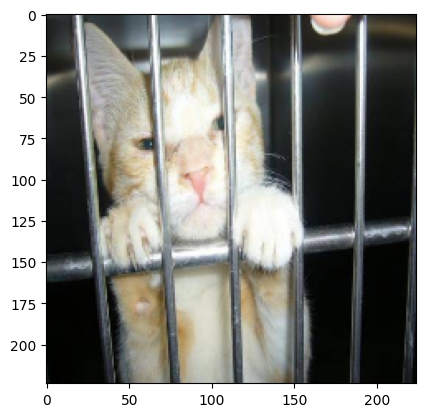

In [29]:
plt.imshow(img)

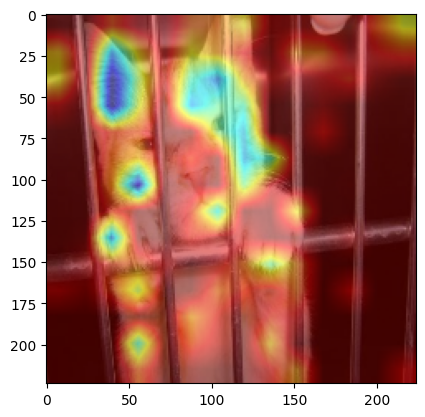

In [30]:
plt.imshow(visualization)